In [185]:
## General script for running correlation (Pearson + Spearman) tests on the data that I extrapolated from YouTube and Spotify. 
## This is more efficient, rather than making twenty-to-twenty five different scripts and individually editing them. Here I can account for potential test cases. 

from pathlib import Path
from typing import Optional, List, Dict
from datetime import timedelta
import re, os, sys

In [186]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.patches import Patch
from matplotlib.ticker import FuncFormatter
from scipy.stats import pearsonr, spearmanr

In [187]:
## Project Paths 

project_root = Path("..")
raw_dir = project_root / "data" / "raw" / "chartmetric_exports"
processed_dir = project_root / "data" / "processed"
reports_dir = project_root / "reports" / "visualizations"
reports_dir.mkdir(parents=True, exist_ok=True)

In [188]:
## Directory for List of Pairs and Associated Events.

song_pairs_paths = [processed_dir / "song_pairs.csv", project_root / "data" / "song_pairs.csv"]

events_paths = [processed_dir / "derived_track_events.csv", project_root / "data" / "derived_track_events.csv"]

In [189]:
## Loading helpers (pairs and events - csv files)

def first_existing(paths: List[Path]) -> Optional[Path]:
    for p in paths:
        if p.exists():
            return p
    return None

def load_song_pairs() -> pd.DataFrame:
    sp_path = first_existing(song_pairs_paths)
    if sp_path is None:
        raise FileNotFoundError("song_pairs.csv was not found in expected locations.")
    sp = pd.read_csv(sp_path)
    
    if "pair_id" not in sp.columns:
        raise ValueError("song_pairs.csv missing 'pair_id' column.")
    
    sp["pair_id"] = sp["pair_id"].astype(str).str.strip()
    sp["pair_id_norm"] = sp["pair_id"].str.lower()
    
    for col in ["event_category", "legal_status"]:
        if col in sp.columns:
            sp[col] = sp[col].astype(str).str.strip().str.lower()
    return sp

def load_events() -> pd.DataFrame:
    ev_path = first_existing(events_paths)
    if ev_path is None:
        print("No events file found. Event shading will not be done.")
        return pd.DataFrame(columns=["pair_id", "event_type", "event_date", "platform", "track_role","severity","source","notes"])
    
    ev = pd.read_csv(ev_path)
    ## Normalized names
    rename_map = {
        "Date": "event_date", 
        "Event Date": "event_date", 
        "Pair ID": "pair_id", 
        "Event Type": "event_type", 
        "Platform": "platform"
    }
    
    ev = ev.rename(columns={k:v for k, v in rename_map.items() if k in ev.columns})
    
    ## Normalizing the values. 
    
    if "pair_id" in ev.columns:
        ev["pair_id"] = ev["pair_id"].astype(str).str.strip().str.lower()
    if "event_type" in ev.columns:
        ev["event_type"] = ev["event_type"].astype(str).str.strip().str.lower()
    if "platform" in ev.columns:
        ev["platform"] = ev["platform"].astype(str).str.strip().str.lower()
        ev["platform"] = ev["platform"].replace({
           "yt":"youtube", "ytb":"youtube", "you tube":"youtube", 
           "sp":"spotify", "spt":"spotify"
        })
    
    if "event_date" in ev.columns:
        ev["event_date"] = pd.to_datetime(ev["event_date"], errors="coerce")
    if "severity" in ev.columns:
        ev["severity"] = ev["severity"].astype(str).str.strip().str.lower()
    
    return ev

In [190]:
## Chartmetric Loaders + weekly changes in metrics

def _pair_dir_for_fs(pair_id: str) -> Path:
    """Return the on-disk pair directory (case-insensitive)."""
    candidates = [
        raw_dir / pair_id,
        raw_dir / pair_id.upper(),
        raw_dir / pair_id.lower(),
    ]
    for c in candidates:
        if c.exists():
            return c
    # last resort: scan dirs that start with pair_id (any case)
    if raw_dir.exists():
        for d in raw_dir.iterdir():
            if d.is_dir() and d.name.lower() == pair_id.lower():
                return d
    return raw_dir / pair_id 


def global_metric_files(pair_id: str, role: str, platform: str, metric: str) -> List[Path]:
    """
    Files like: chartmetric_{pair_id}_{role}_{platform}_{metric}*.csv. 
    * allows for multiple versions to be caught. 
    """
    
    pair_dir = raw_dir / pair_id
    if not pair_dir.exists():
        return []
    pattern = f"chartmetric_{pair_id}_{role}_{platform}_{metric}*.csv"
    return sorted(pair_dir.glob(pattern))

def load_single_csv_to_tidy(path: Path) -> Optional[pd.DataFrame]:
    """Return tidy ['date', 'value'] from one Chartmetric export; 
    Nothing wil return if nothing is parseable."""
    try: 
        df = pd.read_csv(path)
    except Exception as e:
        print(f"Couldn't read {path.name}: {e}")
        return None
    
    ## This finds the date column, specifically. 
    date_candidates = [c for c in df.columns if "date" in c.lower() or "day" in c.lower()]
    if not date_candidates:
        print(f"[load_single_csv_to_tidy] {path.name}: no date-like column. Columns: {list(df.columns)}")
        return None
    date_col = date_candidates[0]

    # Finding metric-like column. 
    lower_map = {c.lower(): c for c in df.columns}
    value_candidates = []

    for key, cname in lower_map.items():
        if "popularity" in key:
            value_candidates.append(cname)
        elif "stream" in key:
            value_candidates.append(cname)
        elif "view" in key:
            value_candidates.append(cname)
        elif "like" in key:
            value_candidates.append(cname)
        elif key in ("value", "metric_value"):
            value_candidates.append(cname)

    if not value_candidates:
        print(f"[load_single_csv_to_tidy] {path.name}: no metric-like column. Columns: {list(df.columns)}")
        return None

    val_col = value_candidates[0]

    out = (
        df.rename(columns={date_col: "date", val_col: "value"})
          .assign(date=lambda d: pd.to_datetime(d["date"], errors="coerce"))
          [["date", "value"]]
          .dropna()
          .sort_values("date")
          .reset_index(drop=True)
    )

    if not len(out):
        print(f"[load_single_csv_to_tidy] {path.name}: 0 usable rows after cleaning.")
        return None

    return out

def combine_versions(files: List[Path], metric: str, platform: str) -> Optional[pd.DataFrame]:
    """
    This is just aggregating multiple version files of a given metric:
    - 'popularity' (Spotify): MAX per date (ordinal 0-100; best signal)
    - flows ('streams', 'views', 'likes') -> sum per date (total audience impact quantified)
    """
    if not files:
        return None
    parts = [load_single_csv_to_tidy(f) for f in files]
    parts = [p for p in parts if p is not None and len(p)]
    if not parts:
        return None
    
    ## Stacking all versions on top of each other. 
    
    stacked = pd.concat(parts, axis=0, ignore_index=True)
    
    if metric == "popularity" and platform == "spotify":
        agg = (stacked.groupby("date", as_index=False)["value"].max())
    else: 
        agg = (stacked.groupby("date", as_index=False)["value"].sum())
    
    return agg.sort_values("date").reset_index(drop=True)

def load_metric(pair_id: str, role: str, platform: str, metric: str) -> Optional[pd.DataFrame]:
    files = global_metric_files(pair_id, role, platform, metric)
    if not files:
        return None
    return combine_versions(files, metric=metric, platform=platform)

## Change `min_year`: `int` = (the year derived song was released, depending on which pair we're running the analysis).
def clipping_early_dates(df: Optional[pd.DataFrame], min_year: int = 2022) -> Optional[pd.DataFrame]:
    """Removing clearly spurious early dates from Chartmetric exports"""
    if df is None or df.empty: 
        return df
    df = df[df["date"].dt.year >= min_year].copy()
    if df.empty:
        return None
    return df

In [191]:
def weekly_change(df: Optional[pd.DataFrame], min_year: int = 2022) -> Optional[pd.DataFrame]:
    """
    Convert daily cumulative/flow into weekly change (sum of diffs).
    """
                                        
    if df is None:
        return None
    
    ## Dropping early-dates
    
    df = clipping_early_dates(df, min_year=min_year)
    if df is None or len(df) < 2:
        return None
    
    x = df.copy()
    x["change"] = x["value"].diff().fillna(0).clip(lower=0)
    w = (x.set_index("date")["change"]
         .resample("W").sum().reset_index().rename(columns={"change":"value"}))
    
    return w if len(w) > 1 else None

In [192]:
def merge_on_date(a: Optional[pd.DataFrame], b: Optional[pd.DataFrame]) -> Optional[pd.DataFrame]:
    ## Inner joining by date (with minimum days overlap, for importance).
    if a is None or b is None:
        return None
    m = a.merge(b, on="date", suffixes=("_orig", "_deriv")).dropna()
    return m if len(m) >= 5 else None

In [193]:
## Event shading utilities (aware of both platform and legalities)

## Pair-level tint from event_category + legal_status (from song_pairs.csv)

def pair_tint(event_category: str, legal_status: str) -> tuple[str, float]:
        ec = (event_category or "").lower()
        ls = (legal_status or "").lower()
        
        ## Stronger alpha if disputed/takedown/AI/unauthorized. 
        
        if "takedown" in ls:
            return ("red", 0.28)
        if "disputed" in ls:
            return ("orange", 0.22)
        if "licensed" in ls or "remake_licensed" in ec or "remix_official" in ec:
            return ("green", 0.12)
        if "ai_voice" in ec or "copy_unauthorized" in ec:
            return ("darkred", 0.26)
        return ("lightgray", 0.15)

## Event-type color mapping to match my observed event_type value. 

def eventtype_color(event_type:str) -> str:
    et = (event_type or "").lower()
    
    color_map = {
        "release": "#2ECC71",
        "playlist_add_editorial": "#3498DB", 
        "press_controversy": "#E67E22",       
        "controversy_resolved": "#1ABC9C",    
        "takedown": "#7F8C8D",              
        "court_order": "#7F8C8D",            
        "re_upload": "#F1C40F",               
        "movie_release": "#9B59B6",           
    }
    
    return color_map.get(et, "#BDC3C7")

## Platform routing for events -> which subplot they shade. 
def event_applies_to_panel(ev_platform: str, panel_platform: str) -> bool:
    p = (ev_platform or "").strip().lower()
    if p in ("", "all", "both", "nan", "none"):
        return True
    if p == "spotify": 
        return panel_platform == "spotify"
    if p == "youtube": 
        return panel_platform == "youtube"
    if p == "apple": 
        return panel_platform == "spotify"
    if p == "ott":
        return panel_platform == "youtube"
    return True

def shade_events(ax, ev_df: pd.DataFrame, panel_platform: str, 
                 event_category: str = "", legal_status: str = ""):
    """Shading events for a given subplot, on either platform."""
    if ev_df is None or ev_df.empty:
        return
    
    base_color, base_alpha = pair_tint(event_category, legal_status)
    
    for _, row in ev_df.iterrows():
        d = row.get("event_date")
        if pd.isna(d):
            continue
        et = str(row.get("event_type", "")).lower()
        pl = str(row.get("platform", "")).lower()
        sev = str(row.get("severity", "")).lower()
    
        if not event_applies_to_panel(pl, panel_platform):
            continue

        ## Severity -> Modify alpha accordingly. 

        alpha = base_alpha 
        if sev in ("high", "major", "severe"): alpha = min(alpha + 0.06, 0.35)
        elif sev in ("low", "minor"): alpha = max(alpha - 0.04, 0.08)

        color = eventtype_color(et)

        ## Time Window 
        if et == "release":
            span = 3
        elif et in ("takedown", "court_order"):
            span = 1
        else: 
            span = 2

        ax.axvspan(d - timedelta(days=span), d + timedelta(days=span), color=color, alpha=alpha)
    
def add_legend(fig):
    ## Adding a legend to show the mapping colors. 
    patches = [
        Patch(facecolor="#2ECC71", alpha=0.20, label="Release"),
        Patch(facecolor="#3498DB", alpha=0.20, label="Editorial Playlist Add"),
        Patch(facecolor="#E67E22", alpha=0.20, label="Press Controversy"),
        Patch(facecolor="#1ABC9C", alpha=0.20, label="Controversy Resolved"),
        Patch(facecolor="#7F8C8D", alpha=0.20, label="Takedown / Court Order"),
        Patch(facecolor="#F1C40F", alpha=0.20, label="Re-Upload"),
        Patch(facecolor="#9B59B6", alpha=0.20, label="Movie Release"),
    ]
    fig.legend(handles=patches, loc="upper center", ncol=3, frameon=False, bbox_to_anchor=(.5, 1.02))
    

In [194]:
## Per-pair analysis (for each, individual PAIR00X....)

def analyze_pair(pair_id: str, events_all: pd.DataFrame, song_pairs: pd.DataFrame) -> pd.DataFrame:
    pid = str(pair_id).strip()
    
    meta = song_pairs[song_pairs["pair_id"] == pid.lower()]
    event_category = meta["event_category"].iloc[0] if not meta.empty and "event_category" in meta else ""
    legal_status = meta["legal_status"].iloc[0] if not meta.empty and "legal_status" in meta else ""
    
    ## Load metrics (aware of multiple versions)
    sp_o_pop = load_metric(pid, "original", "spotify", "popularity")
    sp_d_pop = load_metric(pid, "derived", "spotify", "popularity")
    
    sp_o_streams = load_metric(pid, "original", "spotify", "streams")
    sp_d_streams = load_metric(pid, "derived", "spotify", "streams")
    
    yt_o_views = load_metric(pid, "original", "youtube", "views")
    yt_d_views = load_metric(pid, "derived", "youtube", "views")
    
    yt_o_likes = load_metric(pid, "original", "youtube", "likes")
    yt_d_likes = load_metric(pid, "derived", "youtube", "likes")
    
    ## Weekly changes
    wk_sp_o = weekly_change(sp_o_streams)
    wk_sp_d = weekly_change(sp_d_streams)
    wk_ytv_o = weekly_change(yt_o_views)
    wk_ytv_d = weekly_change(yt_d_views)
    wk_ytl_o = weekly_change(yt_o_likes)
    wk_ytl_d = weekly_change(yt_d_likes)
    
    rows = []
    
    ## Popularity (levels): Spearman primary; also reports Pearson. 
    
    pop_m = merge_on_date(sp_o_pop, sp_d_pop)
    if pop_m is not None:
        rows.append(["levels_spotify_popularity", len(pop_m), 
                     pearsonr(pop_m["value_orig"], pop_m["value_deriv"])[0],
                     spearmanr(pop_m["value_orig"], pop_m["value_deriv"]).correlation])
    else: 
        rows.append(["levels_spotify_popularity", 0, np.nan, np.nan])
        
    
    ## Spotify streams (weekly changes): Pearson (along with Spearman for robustness).
    
    sp_m = merge_on_date(wk_sp_o, wk_sp_d)
    if sp_m is not None:
        rows.append(["Spotify Streams (Weekly Changes)", len(sp_m), 
                    pearsonr(sp_m["value_orig"], sp_m["value_deriv"])[0],
                    spearmanr(sp_m["value_orig"], sp_m["value_deriv"]).correlation])
        
    else: 
        rows.append(["Spotify Streams (Weekly Changes)", 0, np.nan, np.nan])
        
    ## YouTube views (Weekly Changes): Pearson (and Spearman)
    
    if wk_ytv_o is not None and wk_ytv_d is not None:
        ytv_m = merge_on_date(wk_ytv_o, wk_ytv_d)
        if ytv_m is not None:
            rows.append(["YouTube Views (Weekly Changes)", len(ytv_m),
                         pearsonr(ytv_m["value_orig"], ytv_m["value_deriv"])[0],
                         spearmanr(ytv_m["value_orig"], ytv_m["value_deriv"]).correlation])
        else:
            rows.append(["YouTube Views (Weekly Changes)", 0, np.nan, np.nan])
    else: ## Skipping entirely since data isn't available. 
        pass
        
    ## YouTube Likes (Weekly Changes): Pearson (+ Spearman)
    ytl_m = merge_on_date(wk_ytl_o, wk_ytl_d)
    if ytl_m is not None:
        rows.append(["YouTube Likes (Weekly Changes)", len(ytl_m), 
                     pearsonr(ytl_m["value_orig"], ytl_m["value_deriv"])[0],
                     spearmanr(ytl_m["value_orig"], ytl_m["value_deriv"]).correlation])
    else: 
        rows.append(["YouTube Likes (Weekly Changes)", 0, np.nan, np.nan])
        
    corr_df = pd.DataFrame(rows, columns=["metric", "n_overlap", "pearson", "spearman"])
    corr_df.insert(0, "pair_id", pid)
    
    corr_df["pearson"] = corr_df["pearson"].round(3)
    corr_df["spearman"] = corr_df["spearman"].round(3)
    
    ## Pair-associated events. 
    
    ev_pair = events_all.copy()
    if not ev_pair.empty and "pair_id" in ev_pair.columns:
        ev_pair = ev_pair[ev_pair["pair_id"] == pid.lower()].dropna(subset=["event_date"])
    
    ## Building panels on availability. 
    panels = []
    pop_o = sp_o_pop if sp_o_pop is not None and len(sp_o_pop) > 1 else None
    pop_d = sp_d_pop if sp_d_pop is not None and len(sp_d_pop) > 1 else None
    if (pop_o is not None) or (pop_d is not None):
        panels.append(("Spotify Popularity (Levels)", pop_o, pop_d, "levels_pop", "spotify"))
    
    if (wk_sp_o is not None) or (wk_sp_d is not None):
        panels.append(("Spotify Streams - Weekly Changes", wk_sp_o, wk_sp_d, "wk_streams", "spotify"))
    
    if wk_ytv_o is not None and wk_ytv_d is not None:
        panels.append(("YouTube Views - Weekly Changes", wk_ytv_o, wk_ytv_d, "wk_views", "youtube"))
        
    if wk_ytl_o is not None and wk_ytl_d is not None:
        panels.append(("YouTube Likes - Weekly Changes", wk_ytl_o, wk_ytl_d, "wk_likes", "youtube"))
        
    ## Plotting function.
    if panels:
        fig, axes = plt.subplots(len(panels), 1, figsize=(14, 3.8 * len(panels)), sharex=False)
        
        if len(panels) == 1:
            axes = [axes]
        fig.subplots_adjust(hspace=1.0)
        
        zoom_start = pd.Timestamp("2022-01-01")
        zoom_end   = pd.Timestamp("2025-12-31")
        
        for ax, (title, dfo, dfd, key, platform) in zip(axes, panels):
            any_line = False
            
            ## Plotting original/derived
            if dfo is not None and len(dfo) > 1:
                ax.plot(dfo["date"], dfo["value"], label="Original", linewidth=1.5)
                any_line = True
            if dfd is not None and len(dfd) > 1:
                ax.plot(dfd["date"], dfd["value"], label="Derived", linewidth=1.5)
                any_line = True
                
            ax.set_xlim(zoom_start, zoom_end)
            
            ax.set_title(title)
                
            if key == "levels_pop":
                ax.set_ylim(0, 100)
            
            if any_line and ev_pair is not None and not ev_pair.empty:
                shade_events(ax, ev_pair, panel_platform=platform, event_category=event_category,
                             legal_status=legal_status)
                ax.legend(loc="upper left", frameon=False)
            
            ax.grid(alpha=0.2)
            ax.xaxis.set_major_locator(mdates.AutoDateLocator())
            ax.xaxis.set_major_formatter(mdates.ConciseDateFormatter(ax.xaxis.get_major_locator()))
            
        ## Universal Title + Legend. 
        fig.suptitle(f"{pid} - Metrics (Levels) + Weekly Changes", fontsize=15, fontweight="bold", y=1.035)
        add_legend(fig)
        
        ## Give extra padding so legend and title don't overlap.
        
        plt.subplots_adjust(top=.92, hspace=0.46)
        result = reports_dir / f"{pid}_metrics_weekly_changes.png"
        fig.savefig(result, dpi=300, bbox_inches="tight")
        plt.show()
        print(f"Saved -> {result}")
    else:
        print(f"{pid}: Unable to plot anything.")
            
    return corr_df



Available pairs: PAIR001, PAIR002, PAIR003, PAIR004, PAIR005, PAIR006, PAIR007, PAIR008, PAIR009, PAIR010, PAIR011, PAIR012, PAIR013, PAIR014, PAIR015, PAIR016, PAIR017, PAIR018, PAIR019, PAIR020, PAIR021, PAIR022, PAIR023, PAIR024, PAIR025
-----------------------------------------------


Enter the PAIR ID to be analyzed:  PAIR001



Analyzing PAIR001 ...



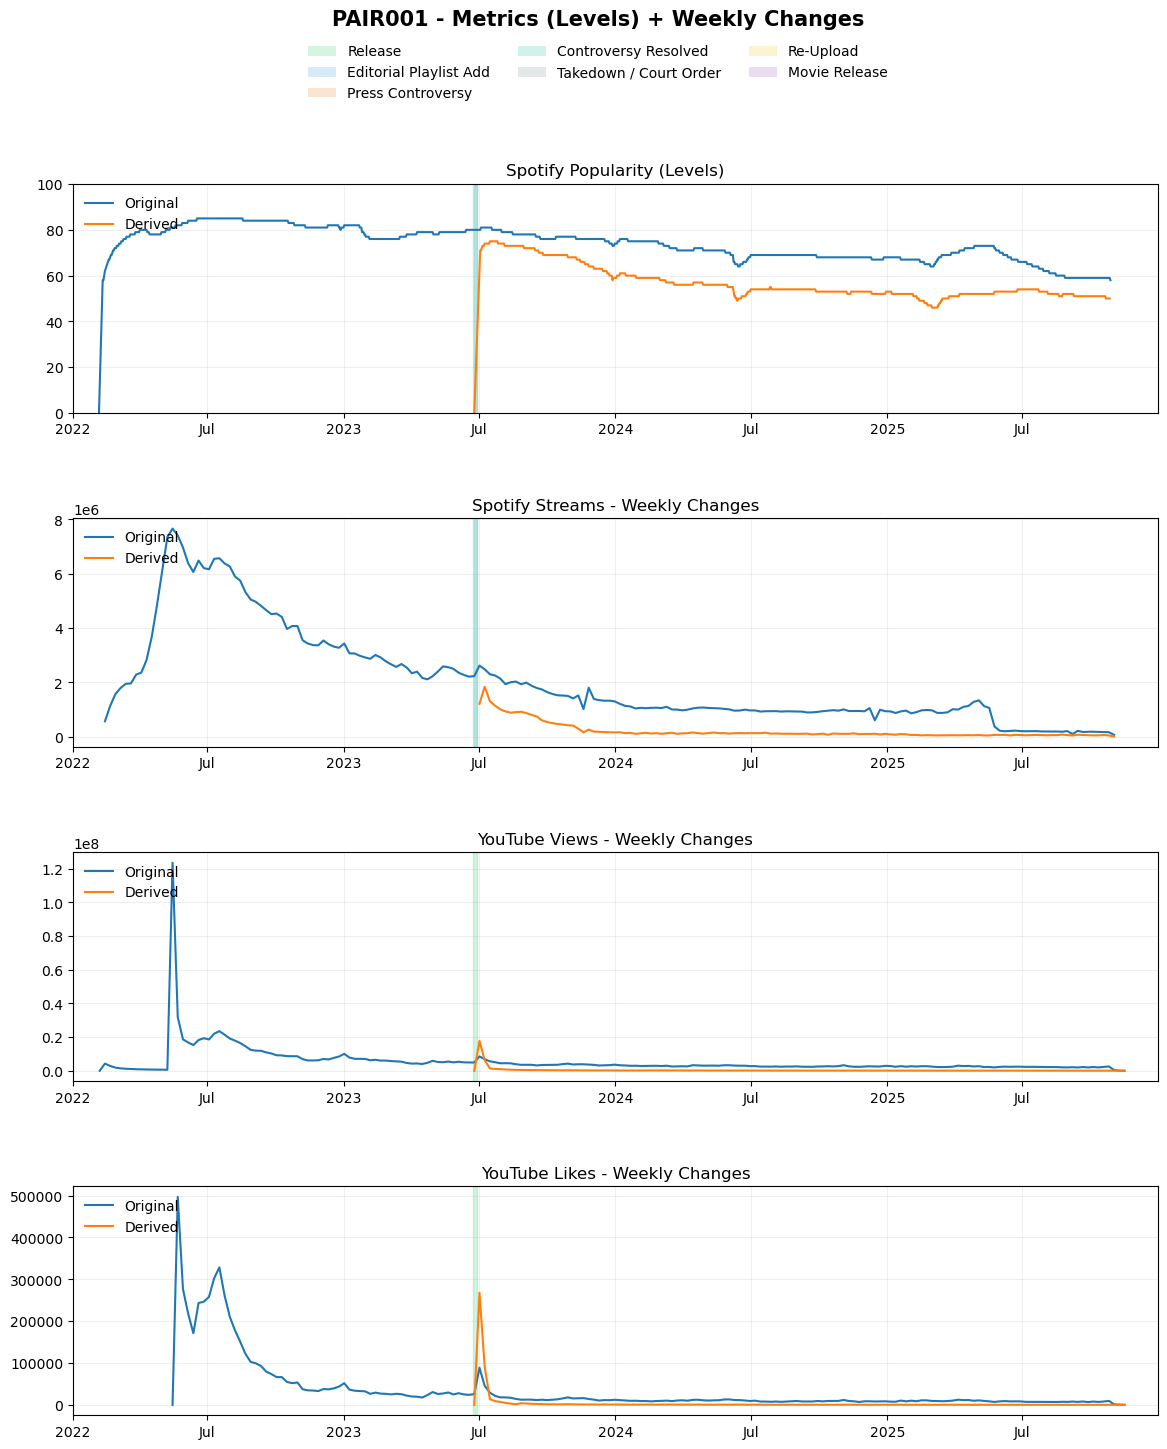

Saved -> ../reports/visualizations/PAIR001_metrics_weekly_changes.png
Saved correlations -> ../reports/visualizations/PAIR001_correlations.csv


In [195]:
## Manual single-pair runner for correlation tests

if __name__ == "__main__":

    song_pairs = load_song_pairs()
    events_all = load_events()

    all_pair_ids = sorted(song_pairs["pair_id"].unique().tolist())
    print("\nAvailable pairs:", ", ".join(all_pair_ids))
    print("-----------------------------------------------")
    
    pid_input = input("Enter the PAIR ID to be analyzed: ").strip()
    
    if pid_input not in all_pair_ids:
        print(f"\n '{pid_input}' not found in song_pairs.csv.")
        print("Try again with one of the listed available IDs above.")
        sys.exit(1)
    
    print(f"\nAnalyzing {pid_input} ...\n")
    
    ## Running analysis for the chosen pair. 
    corr_df = analyze_pair(pid_input, events_all=events_all, song_pairs=song_pairs)
    if corr_df is not None and len(corr_df):
        out_path = reports_dir / f"{pid_input}_correlations.csv"
        corr_df.to_csv(out_path, index=False)
        print(f"Saved correlations -> {out_path}")
    else: 
        print(f"No correlation data produced for {pid_input}.")